<a href="https://colab.research.google.com/github/moulikatou/Ter_securite_Alimentaire_Miashs/blob/vmelancon/notebooks/ter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPORTS & GLOBAL VARIABLES


In [1]:
!pip install pyreadstat
import pandas as pd
import numpy as np
import pyreadstat as pt

import matplotlib.pyplot as plt
import seaborn as sns

path = "/content/drive/MyDrive/COLAB_STUFF/donnees/" # "../TER_M1_MIASHS/donnees/"

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


A __read function__ to convert a .SAV file into a pandas.DataFrame, and a __concat function__ for later to merge all data

In [3]:
'''
desc : from a filename 'fichier' (with an ".sav" extension) returns a DataFrame
return : DataFrame
'''
def lire(fichier):
    df, meta = pt.read_sav(fichier)
    return df

'''
desc : save a dataframe as a CSV file
df : a dataframe to be saved
filename : a string, the path where the file should be saved
'''
def sauver(df, filename):
    return df.to_csv(filename)

'''
desc : concat multiple dataframe, joining the same columns and adding the ones that are different
dfs : a list of DataFrame
return : the concatenation of dfs
'''
def concat(dfs):
    res = dfs[0]
    for i in range(1, len(dfs)):
        res = res.merge(dfs[i], how="outer")
    return res

'''
desc : compute a csi score
X : a dataframe, answers to all five questions {"a":[0-7], "b":[0-7], "c":[0-7], "d":[0-7], "e":[0-7]}
    to compute the CSI score
return : a float, the computed CSI score
'''
def reduced_csi_score(X):
    csi = pd.DataFrame(columns=["answers", "weight", "weighted_score"])
    csi.answers = X
    csi.weight = [1,2,1,3,1]

    csi.weighted_score = csi.answers * csi.weight
    csi.score = csi.weighted_score.sum()
    return csi

# FILE BY FILE

In [4]:
files = ["Base_SA_globale_20182019.sav", "cahier6_final_Prev_20172018.sav", "Cahier6_def_Prev_20162017.sav", "Cahier6_Prev_20152016.sav", "Cahier6_Prev_20142015.sav"]

In [85]:
col = {
    "metadata" : ["REG", "PROV", "COM", "VIL", "MEN", "YEAR"],
    "data" : ["S62Q1_1","S62Q1_2","S62Q1_3","S62Q1_4","S62Q1_5"],
    "target" : ["CSI"]
}
col_to_keep = col["metadata"] + col["data"] + col["target"]

In [17]:
dfs = {}
new_path = path + "formated/"
new_files = []
for f in files:
    df = lire(path + f)
    
    annee = f.split('.')[0].split('_')
    annee = int(annee[len(annee)-1][:4])
    df["YEAR"] = annee
    df[col["target"]] = np.nan

    try:
        df["MEN"] = df.loc[:, "CODMEN"]
    except Exception as e:
        pass

    for i in range(df.shape[0]):
        d = df.iloc[i]
        CSI = reduced_csi_score(d[col["data"]])
        d[col["target"]] = CSI.score
        df.iloc[i] = d

    df = df.loc[:, col_to_keep]

    filename = "donnees_" + str(annee)
    new_files.append(filename)

    sauver(df, path + filename)
    dfs[annee] = df

In [86]:
dfs = {}
new_path = path + "formated/"
new_files = ["donnees_2014", "donnees_2015", "donnees_2016", "donnees_2017", "donnees_2018"]

for f in new_files:
    annee = int(f.split('_')[1])
    df = pd.read_csv(new_path + f)
    df = df.set_index(df.columns[0])
    df[col["metadata"]] = df[col["metadata"]].astype(int)
    dfs[annee] = df

In [20]:
'''
desc : print out a summary of data of a given dataframe
       
       compute the mean of CSI, missing values, the number of houseolds.
df : a dataframe, to be summed up
'''
def summary(df):
    print("NB ROWS : {}".format(df.shape[0]))
    print("COLUMNS : {}".format(list(df.columns)))
    print("Number of households : {}\n".format(df.MEN.unique().shape[0]))
    # print("Number of NaN values :")
    # print(df.isna().sum()[col["data"]], '\n')

    # print("Question 1 missing values : {}".format(df.S62Q1_1.isna().sum()))
    # print("Question 2 missing values : {}".format(df.S62Q1_2.isna().sum()))
    # print("Question 3 missing values : {}".format(df.S62Q1_3.isna().sum()))
    # print("Question 4 missing values : {}".format(df.S62Q1_4.isna().sum()))
    # print("Question 5 missing values : {}".format(df.S62Q1_5.isna().sum()), "\n")

    print("Number of data by town :")
    for com in sorted(df.COM.unique()):
        print("\tTOWN {} : {}(number of rows)".format(com, df[df.COM == com].shape[0]))

    print()
    print(df[col["data"] + col["target"]].describe().to_markdown())

'''
desc : display some plots useful to see what's in the dataframe,
       such as CSI by town, or mean CSI by town ... (vraiment j'ai pas d'idée ...)
df : a dataframe, to be summed up
'''
def plot_question_csi(df):
    df = df.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="ANSWER")

    g = sns.FacetGrid(df, col="QUESTION")
    g.map(sns.boxplot, "ANSWER", "CSI")
    g.add_legend()
    return plt.show()


In [97]:
print(dfs.keys())
annee = 2014
summary(dfs[annee])
# plot_question_csi(dfs[annee])

dict_keys([2014, 2015, 2016, 2017, 2018])
NB ROWS : 5198
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'S62Q1_1', 'S62Q1_2', 'S62Q1_3', 'S62Q1_4', 'S62Q1_5', 'CSI']
Number of households : 717

Number of data by town :
	TOWN 1 : 829(number of rows)
	TOWN 2 : 740(number of rows)
	TOWN 3 : 776(number of rows)
	TOWN 4 : 659(number of rows)
	TOWN 5 : 570(number of rows)
	TOWN 6 : 536(number of rows)
	TOWN 7 : 416(number of rows)
	TOWN 8 : 207(number of rows)
	TOWN 9 : 202(number of rows)
	TOWN 10 : 131(number of rows)
	TOWN 11 : 36(number of rows)
	TOWN 12 : 48(number of rows)
	TOWN 13 : 36(number of rows)
	TOWN 15 : 12(number of rows)

|       |    S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |     S62Q1_5 |        CSI |
|:------|-----------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5173       | 5165        | 5164        | 5163        | 5162        | 5198       |
| mean  |    1.06263 |    0.294482 |    0.998257 |    0.787914 |    0.94440

In [98]:
annee = 2015
summary(dfs[annee])
# plot_question_csi(dfs[annee])

NB ROWS : 5157
COLUMNS : ['REG', 'PROV', 'COM', 'VIL', 'MEN', 'YEAR', 'S62Q1_1', 'S62Q1_2', 'S62Q1_3', 'S62Q1_4', 'S62Q1_5', 'CSI']
Number of households : 712

Number of data by town :
	TOWN 1 : 825(number of rows)
	TOWN 2 : 732(number of rows)
	TOWN 3 : 769(number of rows)
	TOWN 4 : 653(number of rows)
	TOWN 5 : 571(number of rows)
	TOWN 6 : 520(number of rows)
	TOWN 7 : 410(number of rows)
	TOWN 8 : 205(number of rows)
	TOWN 9 : 206(number of rows)
	TOWN 10 : 130(number of rows)
	TOWN 11 : 40(number of rows)
	TOWN 12 : 48(number of rows)
	TOWN 13 : 36(number of rows)
	TOWN 15 : 12(number of rows)

|       |     S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |     S62Q1_5 |        CSI |
|:------|------------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5144        | 5074        | 5073        | 5067        | 5064        | 5157       |
| mean  |    0.880832 |    0.215412 |    0.777252 |    0.561279 |    0.718602 |    4.42719 |
| std   |    1.7574  

In [23]:
# annee = 2016
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

In [24]:
# annee = 2017
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

In [25]:
# annee = 2018
# summary(dfs[annee])
# plot_question_csi(dfs[annee])

|       |    S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |     S62Q1_5 |        CSI |
|:------|-----------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5173       | 5165        | 5164        | 5163        | 5162        | 5198       |
| mean  |    1.06263 |    0.294482 |    0.998257 |    0.787914 |    0.944401 |    5.92016 |
| std   |    1.88676 |    0.932573 |    1.93628  |    1.76313  |    1.94285  |    9.82212 |
| min   |    0       |    0        |    0        |    0        |    0        |    0       |
| 25%   |    0       |    0        |    0        |    0        |    0        |    0       |
| 50%   |    0       |    0        |    0        |    0        |    0        |    0       |
| 75%   |    2       |    0        |    1        |    0        |    1        |    8       |
| max   |    7       |    7        |    7        |    7        |    7        |   56       |


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


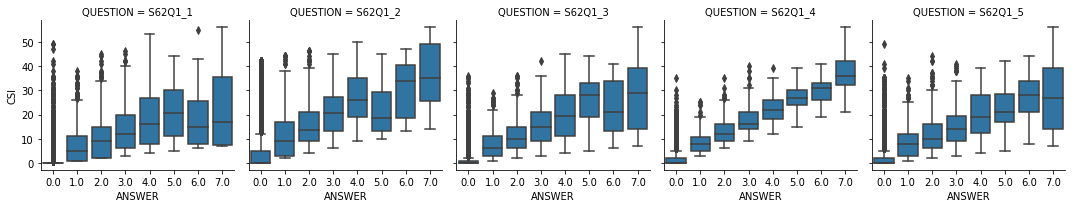

|       |     S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |     S62Q1_5 |        CSI |
|:------|------------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5144        | 5074        | 5073        | 5067        | 5064        | 5157       |
| mean  |    0.880832 |    0.215412 |    0.777252 |    0.561279 |    0.718602 |    4.42719 |
| std   |    1.7574   |    0.813056 |    1.74262  |    1.52643  |    1.74924  |    8.76207 |
| min   |    0        |    0        |    0        |    0        |    0        |    0       |
| 25%   |    0        |    0        |    0        |    0        |    0        |    0       |
| 50%   |    0        |    0        |    0        |    0        |    0        |    0       |
| 75%   |    1        |    0        |    0        |    0        |    0        |    5       |
| max   |    7        |    7        |    7        |    7        |    7        |   56       |


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


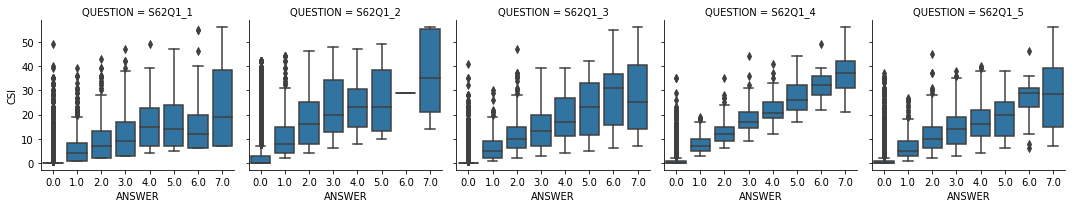

|       |     S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |    S62Q1_5 |        CSI |
|:------|------------:|------------:|------------:|------------:|-----------:|-----------:|
| count | 5181        | 5146        | 5145        | 5144        | 5141       | 5233       |
| mean  |    0.736537 |    0.187913 |    0.643149 |    0.446734 |    0.56098 |    3.59966 |
| std   |    1.62375  |    0.760963 |    1.61657  |    1.35204  |    1.54165 |    7.88323 |
| min   |    0        |    0        |    0        |    0        |    0       |    0       |
| 25%   |    0        |    0        |    0        |    0        |    0       |    0       |
| 50%   |    0        |    0        |    0        |    0        |    0       |    0       |
| 75%   |    1        |    0        |    0        |    0        |    0       |    3       |
| max   |    7        |    7        |    7        |    7        |    7       |   56       |


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


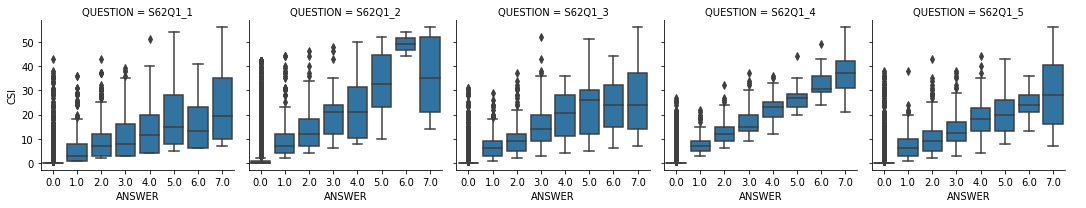

|       |     S62Q1_1 |     S62Q1_2 |     S62Q1_3 |     S62Q1_4 |     S62Q1_5 |        CSI |
|:------|------------:|------------:|------------:|------------:|------------:|-----------:|
| count | 5185        | 5182        | 5184        | 5183        | 5181        | 5232       |
| mean  |    0.980135 |    0.183906 |    0.728395 |    0.506656 |    0.704111 |    4.26032 |
| std   |    1.84722  |    0.77424  |    1.6835   |    1.39273  |    1.73146  |    8.52609 |
| min   |    0        |    0        |    0        |    0        |    0        |    0       |
| 25%   |    0        |    0        |    0        |    0        |    0        |    0       |
| 50%   |    0        |    0        |    0        |    0        |    0        |    0       |
| 75%   |    1        |    0        |    0        |    0        |    0        |    5       |
| max   |    7        |    7        |    7        |    7        |    7        |   56       |


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


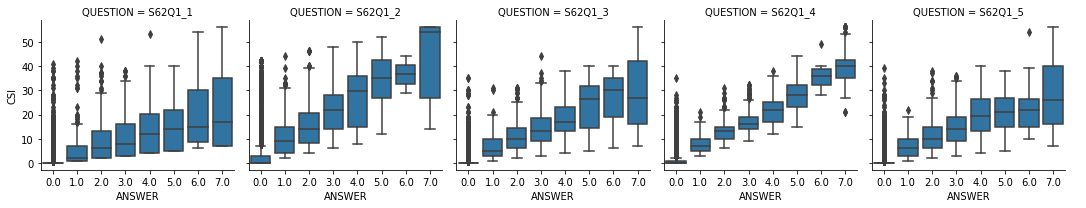

|       |    S62Q1_1 |     S62Q1_2 |     S62Q1_3 |    S62Q1_4 |    S62Q1_5 |        CSI |
|:------|-----------:|------------:|------------:|-----------:|-----------:|-----------:|
| count | 5157       | 5149        | 5147        | 5146       | 5145       | 5165       |
| mean  |    1.05701 |    0.180618 |    0.870021 |    0.59658 |    0.76171 |    4.82439 |
| std   |    1.90846 |    0.77098  |    1.90465  |    1.56843 |    1.83653 |    9.42856 |
| min   |    0       |    0        |    0        |    0       |    0       |    0       |
| 25%   |    0       |    0        |    0        |    0       |    0       |    0       |
| 50%   |    0       |    0        |    0        |    0       |    0       |    0       |
| 75%   |    2       |    0        |    0        |    0       |    0       |    5       |
| max   |    7       |    7        |    7        |    7       |    7       |   56       |


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


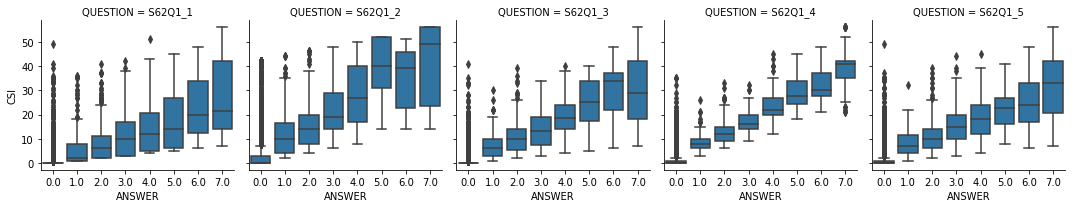

In [26]:
for k in dfs:
    # print(k)
    df = dfs[k]
    print(df[col["data"] + col["target"]].describe().to_markdown())
    plot_question_csi(df)


# COMPARISON OF EVERY YEAR

In [ ]:
# allez hop hop hop on plot

# CONCAT EVERY DATA FILE
Some functions we'll use to concat those files, we then add a column refering to the year of the file.

In [87]:
dfs_list = [dfs[2014], dfs[2015], dfs[2016], dfs[2017], dfs[2018]]
raw_data = concat(dfs_list)

# SAVES ALL DATA CONCATENED IN A CSV FILE
raw_data.to_csv(path + 'donnees.csv')
# raw_data[col["metadata"]] = raw_data[col["metadata"]].astype(int)
mask = (raw_data[col["data"]])
raw_data

,REG,PROV,COM,VIL,MEN,YEAR,S62Q1_1,S62Q1_2,S62Q1_3,S62Q1_4,S62Q1_5,CSI
0,1,13,1,1,45,2014,0.0,0.0,0.0,0.0,0.0,0.0
1,1,13,1,1,57,2014,0.0,0.0,0.0,0.0,0.0,0.0
2,1,13,1,1,58,2014,0.0,0.0,0.0,0.0,0.0,0.0
3,1,13,1,1,67,2014,0.0,0.0,0.0,0.0,0.0,0.0
4,1,13,1,1,84,2014,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
25980,13,41,5,14,39,2018,2.0,0.0,1.0,1.0,1.0,7.0
25981,13,41,5,14,43,2018,2.0,0.0,1.0,1.0,1.0,7.0
25982,13,41,5,14,53,2018,1.0,0.0,0.0,1.0,0.0,4.0
25983,13,41,5,14,68,2018,2.0,0.0,2.0,1.0,0.0,7.0


In [88]:
print("NB DE COM : {}".format(raw_data.COM.unique().shape[0]))
print("NB DE PROV : {}".format(raw_data.PROV.unique().shape[0]))
print("NB DE REG : {}".format(raw_data.REG.unique().shape[0]))

print(raw_data[col["data"] + col["target"]].describe().to_markdown())

NB DE COM : 16
NB DE PROV : 45
NB DE REG : 13
|       |      S62Q1_1 |      S62Q1_2 |      S62Q1_3 |      S62Q1_4 |      S62Q1_5 |         CSI |
|:------|-------------:|-------------:|-------------:|-------------:|-------------:|------------:|
| count | 25840        | 25716        | 25713        | 25703        | 25693        | 25985       |
| mean  |     0.943382 |     0.212475 |     0.803524 |     0.579932 |     0.738139 |     4.60454 |
| std   |     1.8117   |     0.813961 |     1.78521  |     1.53178  |     1.76967  |     8.94059 |
| min   |     0        |     0        |     0        |     0        |     0        |     0       |
| 25%   |     0        |     0        |     0        |     0        |     0        |     0       |
| 50%   |     0        |     0        |     0        |     0        |     0        |     0       |
| 75%   |     1        |     0        |     0        |     0        |     0        |     5       |
| max   |     7        |     7        |     7        |     7   

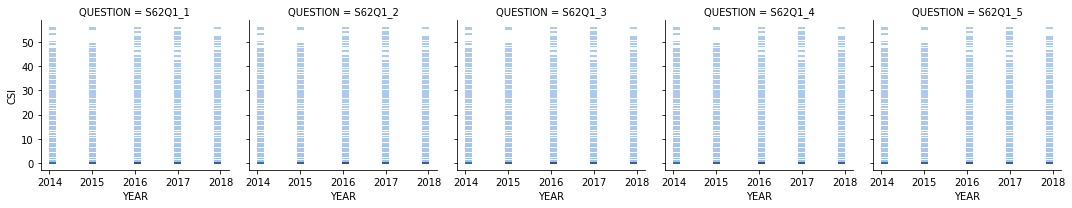

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


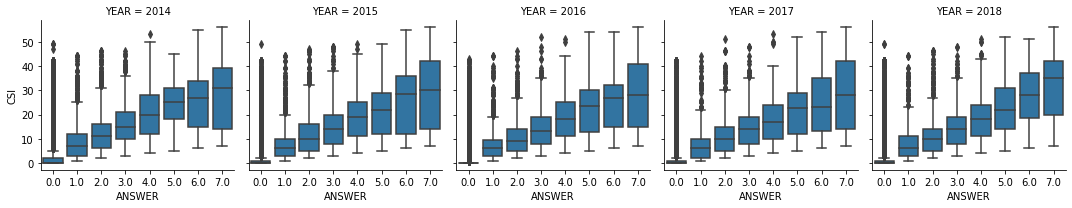

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


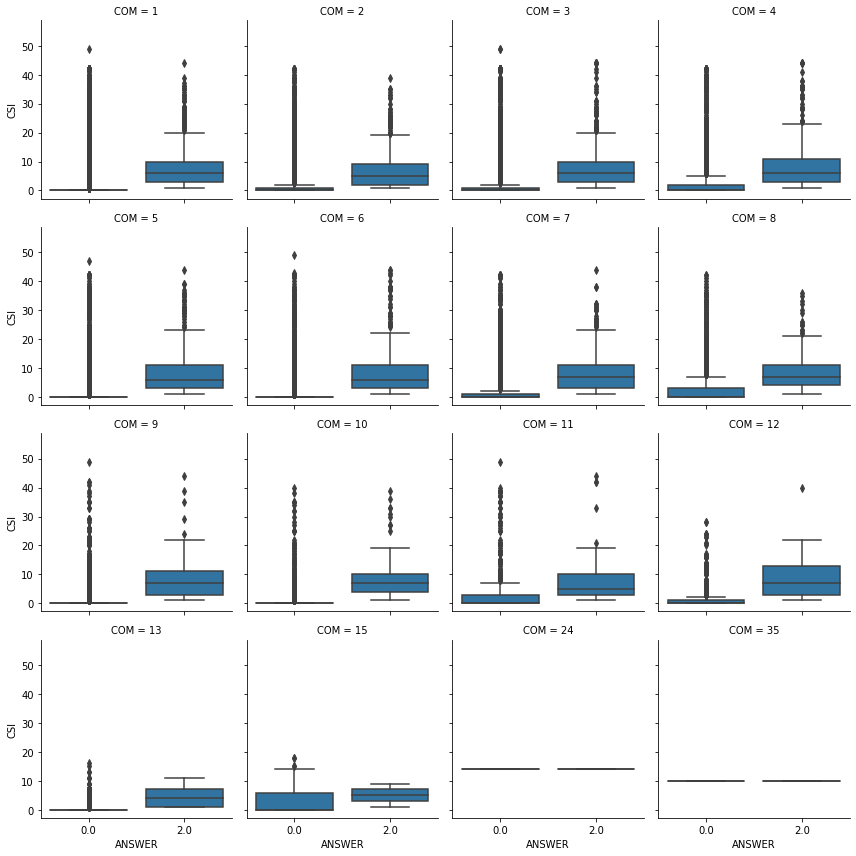

In [99]:
plot_data = raw_data.melt(id_vars=(col["metadata"] + col["target"]), var_name="QUESTION", value_name="ANSWER")

g = sns.FacetGrid(plot_data, col="QUESTION")
g.map(sns.histplot, "YEAR", "CSI")# hue="QUESTION")
plt.show()

g = sns.FacetGrid(plot_data, col="YEAR")
g.map(sns.boxplot, "ANSWER", "CSI")# hue="QUESTION")
plt.show()

g = sns.FacetGrid(plot_data, col="COM", col_wrap=4)
g.map(sns.boxplot, "ANSWER", "CSI")# hue="YEAR")
plt.show()
# plot_data["SUM"] = 


In [95]:
data_clean = pd.DataFrame()

data_clean[col["metadata"]] = raw_data[col["metadata"]]
data_clean[col["target"]] = raw_data[col["target"]]

data_clean[""]
for c in col["data"]:
    mask = (raw_data[c] == 0)
    data_clean[c] = raw_data[mask]

ValueError: ignored

# ANALYSE

Certaines colonnes ont des noms différents et représentant la même métrique, d'autres ne nous intéresse tout simplement pas.
On veut alors essayer de réduire le nombre de colonnes.

__D'abord quelques infos à propos du jeu de données__

In [41]:
# print("Total rows : {}\n".format(raw_data.shape[0]))

# print("Number of rows containing a NaN value in each columns\n{}".format(raw_data.isna().sum()))

# print("\nNumbers of rows by year")
# for (year) in (raw_data.YEAR.unique()):
#     print("\t {} : {}".format(year, raw_data[raw_data.YEAR == year].shape[0]))

Let's see if there is the same amount of data over the years :

In [42]:
# for year in raw_data.YEAR.unique():
#     print("YEAR {}/{} :".format(year[:4], year[4:]))
#     print("\tNumber of missing CSI rows : {}/{}".format(raw_data[raw_data.YEAR == year].CSI.isna().sum(),
#                                                         raw_data[raw_data.YEAR == year].shape[0]))
#     print("\tNumber of REG : {}".format(raw_data[raw_data.YEAR == year].loc[:, "REG"].unique().shape[0]))
#     print("\tNumber of PROV : {}".format(raw_data[raw_data.YEAR == year].loc[:, "PROV"].unique().shape[0]))
#     print("\tNumber of COM : {}".format(raw_data[raw_data.YEAR == year].loc[:, "COM"].unique().shape[0]))
#     print("\tNumber of VIL : {}".format(raw_data[raw_data.YEAR == year].loc[:, "VIL"].unique().shape[0]))
    

__Now let's focus on columns that we're interested in :__

In [38]:
# for col in raw_data.columns:
#     print(col)

In [ ]:
# All those columns, are answers to different questions ask to compute a CSI score.
# don't know the difference between S62 and S63,
# some rows answer only to S62 questions, some answers to all S62 and S63 questions

S62_Q1 = ["S62Q1_1","S62Q1_2","S62Q1_3","S62Q1_4","S62Q1_5"]
S62_Q2 = ["S62Q21_1","S62Q21_2","S62Q22_1","S62Q22_2","S62Q23_1","S62Q23_2","S62Q24_1","S62Q24_2","S62Q25_1","S62Q25_2","S62Q26_1","S62Q26_2","S62Q27_1","S62Q27_2","S62Q28_1","S62Q28_2","S62Q29_1","S62Q29_2","S62Q210_1","S62Q210_2"]
S62_Q3 = ["S62Q3"]
S62_Q4 = ["S62Q4_1","S62Q5_1","S62Q4_2","S62Q5_2","S62Q4_3"]
S62_Q5 = ["S62Q5_3","S62Q2","S62Q3_1","S62Q3_2","S62Q3_3"]
S62_COR_DEF = ["S62Q2_c","S62Q4_3_cor1","S62Q2_1","S62Q3_cor","S62Q4_1_cor","S62Q4_1_def","S62Q4_2_cor","S62Q4_2_def","S62Q4_3_cor","S62Q4_3_def","S62Q5_1_cor","S62Q5_1_def","S62Q5_2_cor","S62Q5_2_def","S62Q5_3_cor","S62Q5_3_def", "S62Q24_1_COR","S62Q4_1_COR"]
S62 = S62_Q1 + S62_Q2 + S62_Q3 + S62_Q4 + S62_Q5 #+ S62_COR_DEF

S63_Q1 = ["S63Q1_A","S63Q1_B","S63Q1_C","S63Q1_D","S63Q1_E","S63Q1_F","S63Q1_G","S63Q1_H","S63Q1_I","S63Q1_J","S63Q1_K","S63Q1_L","S63Q1_M"]
S63_Q2 = ["S63Q2_A","S63Q2_B","S63Q2_C","S63Q2_D"]
S63_Q3 = ["S63Q3_A","S63Q3_B","S63Q3_C","S63Q3_D","S63Q3_E","S63Q3_F","S63Q3_G","S63Q3_H","S63Q3_I","S63Q3_J","S63Q3_K"]
S63 = S63_Q1 + S63_Q2 + S63_Q3

STRATEGIE = ["Stratégie1","Stratégie2","Stratégie3","Stratégie4","Stratégie5"]

# "CSI","YEAR" : those are also useful,
# the CSI column will surely be our target column, while S63 and S62 arrays will be our variables
# "REG", "PROV", "COM", "VIL" could also be considered, but not so sure about that yet

COL_TO_KEEP = ["REG", "COM", "PROV", "VIL", "MEN", "YEAR"]
COL_TO_KEEP += S62_Q1


__Some info about the S62 and S63 columns and some other columns__

We'll add some plots when we'll know what does the columns represent

In [39]:
# Number of NaN values in each column of S62 type
# raw_data.loc[:, S62].isna().sum()

In [40]:
# Number of NaN values in each column of S63 type
# raw_data.loc[:, S63].isna().sum()

In [ ]:
# Number of NaN values in CSI column
raw_data.loc[:, "CSI"].isna().sum()

10537

You can notice that half the data is not mesured, some rows could be filled by calculating the CSI with the help of all S62 and S63 columns. 

# FEATURE ENGINEERING
----
We'll see if there is any transformation needed in the data, we could also complete some rows by computing the CSI score.

# MODELING